In [2]:
#Importing some tools things to begin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#Let's quickly load our data
train_path = 'train.csv'

def load_data(path, drop_cols=None):
    if drop_cols:
        df = pd.read_csv(path, header=0)
        df = df.drop(drop_cols, axis=1)
        return df
    return pd.read_csv(path, header=0)

train = load_data(train_path, drop_cols=['ID']) #We don't need the IDs

We want to get some basic information from our dataset like
what type of information we can find and what our target vector

In [4]:
#What does our training data look like?
train.get_dtype_counts()

float64      1
int64      368
object       8
dtype: int64

It looks like we have mostly numerical values in our dataset. We also
have 8 categorical columns. Since we are using the sci-kit learn library to train a model, we'll need to convert these values to numerical values. We'll want to one hot encode these columns --> make every category into a binary 1 or 0 value. This prevents the magnitude of the numerical variables from affecting your model. We only want the presence of a category as the feature. Keep this in mind for later.  

In [5]:
#What does our target vector look like?
train['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

On average, the value of our target vector is ~100. No values fall below 72.11 and most of the data lies between ~90 and ~109. We can see that this bell curve also has a heavy tail because the maximum value we can get is 265.32 most of the data lies around ~100. Let's visualize it! 

(array([  71.,   69.,   27.,  178.,  831.,  543.,  387.,  372.,  361.,
         545.,  359.,  191.,  104.,   49.,   41.,   20.,   20.,   14.,
           5.,    5.,    5.,    5.,    3.,    0.,    2.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  72.11  ,   75.9742,   79.8384,   83.7026,   87.5668,   91.431 ,
          95.2952,   99.1594,  103.0236,  106.8878,  110.752 ,  114.6162,
         118.4804,  122.3446,  126.2088,  130.073 ,  133.9372,  137.8014,
         141.6656,  145.5298,  149.394 ,  153.2582,  157.1224,  160.9866,
         164.8508,  168.715 ,  172.5792,  176.4434,  180.3076,  184.1718,
         188.036 ,  191.9002,  195.7644,  199.6286,  203.4928,  207.357 ,
         211.2212,  215.0854,  218.9496,  222.8138,  226.678 ,  230.5422,
         234.4064,  238.2706,  242.1348,  245.999 ,  249.8632,  253.7274,
        

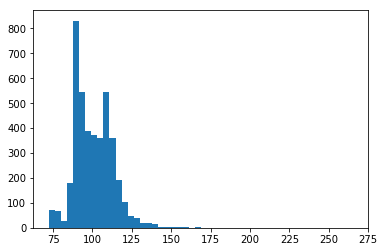

In [6]:
plt.hist(train['y'], bins=50)

Seeing what our target vector looks like helps us keep into context what our predictions should look like. If we get values that look remotely like this, we know we're getting somewhere.

Let's start diving in and trying some basic techniques.
We'll start by dividing our data into a training set and a validation set. A validation set allows us to score our model after training it using the training set. The validation set is a small subset of the training data (I normally choose 20% of the training data for a validation set). It is put away not to be seen by the model so we can be sure the model is being tested on new data for which we have labels to score. 
We're going to be using the ml_tools library which you can find here:
https://github.com/mayorquinmachines/ml_tools

We'll load the data again using the DataPrep class so that we can load all of our sets and preprocess the data with some basic transformers

In [7]:
from ml_tools.dataprep import DataPrep
#"y" is our target vector, and "ID" are ids we don't need for training
prep = DataPrep(dummy_pipe=True, target="y", identifier="ID") 
X_train, y_train, X_val, y_val, test, test_id = prep.load_data('train.csv', 'test.csv')
X_train, X_val, test = prep.transform(X_train, X_val, test)

/home/kirk/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Awesome! We have all of our data sets transformed uniformly and split into the categories needed. If you look into the dataprep.py script of the ml_tools package, you'll see that it takes several steps to load, split, and transform the data. Let's go through the steps it took:

* We initialized the class with the dummy_pipe flag set to True. We saw earlier that our data had categorical data and we were going to need to one hot encode those. 

* The load_data() method loads both train and test file paths and uses sci-kit learn's train_test_split. This method randomly shuffles your data and splits it into what we call the X_train and X_val sets with their respective y vectors.

* When we call the transform() on the training, validation, and test sets, DataPrep remembers that we wanted to use the dummy_pipe. The dummy_pipe is part of the Pipes() class. This pipe will:
    * Find all the common columns for all the data sets
    * Apply Dummifier(), a custom transformer that will one hot encode all of the categorical columns
    * Apply DataSelector(), a custom transformer that will transform a pandas dataframe to a numpy array. 
    * Apply StandardScaler(), a sci-kit learn transformer that will standardize our data.

With a very basic foundation, we can start testing some models. Here are some good starters to play with:

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

forest = RandomForestRegressor(n_jobs=-1)
gradient_boost = GradientBoostingRegressor()
elastic_net = ElasticNet()

In [9]:
#Train some models
forest.fit(X_train, y_train)
gradient_boost.fit(X_train, y_train)
elastic_net.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
#Get some predictions using the validation set
forest_preds = forest.predict(X_val)
gradient_preds = gradient_boost.predict(X_val)
elastic_preds = elastic_net.predict(X_val)

In [11]:
#How well did they do?
from sklearn.metrics import r2_score
forest_score = r2_score(y_val, forest_preds)
gradient_score = r2_score(y_val, gradient_preds)
elastic_score = r2_score(y_val, elastic_preds)

In [12]:
print forest_score, gradient_score, elastic_score

0.385519266295 0.570160502223 0.567177813899


Looks like some of these models didn't do half bad with default parameters! From here there's plenty you can do (like going back and preprocessing your data in a new way!). For now, let's experiment and see what we can do by tuning hyperparameters. 

We can use sci-kit learn's GridSearchCV! Grid search allows you to search through a set of parameters. For example:

    Say we want to find some good hyperparameters for the random forest model. For this example, we have two parameters we'd like to play with: n_estimators and n_components.
    
    * for n_estimators we want to test these values: [100,200,300]
    * for n_components we want to test these values: [50,100,150]
    
    If we choose to do a 5-fold cross validation, just for this model we have length(n_estimatos) x length(n_components) = 9 combinations of hyperparameters * 5 rounds of training = 45 models!
    

As you can see, GridSearchCV makes it easy to test many combinations of hyperparameters very thoroughly. However these calculations take a lot of time. Hyperparameter sweeps are best to be done after doing some more data wrangling and selecting the best combination of features, or potentially getting more data. Tuning parameters should give you the cherry on top. Here's a quick demostration on how long these calculations can take:

In [15]:
#Let's test how long each of these take in time!
import time
from sklearn.model_selection import GridSearchCV


def timer(command):
    start = time.time()
    exec(command)
    end = time.time()
    return end - start

#Random Forest Grid Search
forest_param_grid = [
    {'n_estimators':[100,200,300],
     'max_features':[50, 100,150],
     }
]
grid_search_forest = GridSearchCV(forest, forest_param_grid, cv=5, scoring='r2')
forest_fit_time = timer('grid_search_forest.fit(X_train, y_train.ravel())')
print 'Forest search time: ' + str(forest_fit_time)
print


Forest search time: 98.0270929337



That took over a minute to look over these hyperparameters! After seeing the results of the best parameters you might decide that you want to through more options. This could take a while and so this is best left to be done after you've gotten more juice out of your data. For demonstration purposes, let's look at what results we can get with one of our better performing models: Gradient Boost

In [27]:
#Gradient Boost
gradient_param_grid = [
    {'n_estimators':[50,100],
     'max_features':[100,200],
     }
]
grid_search_gradient = GridSearchCV(gradient_boost, gradient_param_grid, cv=5, scoring='r2')
grid_search_gradient.fit(X_train, y_train.ravel())
print 'Best Parameters: '+ str(grid_search_gradient.best_params_)
print 'Mean test scores: '+ str(grid_search_gradient.cv_results_['mean_test_score'])

Best Parameters: {'max_features': 100, 'n_estimators': 50}
Mean test scores: [ 0.56120265  0.55395658  0.55901349  0.55497054]


It looks like we'll have to do some more parameter sweeping to find a combination that does better than our default model. We should go back and look at what we can do with the data before experimenting any further with more algorithms. 